We implement Network in Network from the original [paper](https://arxiv.org/abs/1312.4400)

### Dataset
The goal is to train an Network in Network architecture on a subset of ImageNet ([ImageNet-100](https://www.kaggle.com/datasets/ambityga/imagenet100)). Images have high resolution and for our training, we used 224x224 images.

In [1]:
import numpy as np
import torchvision

import dataset

In [2]:
batch_size = 128

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=256),
    torchvision.transforms.ToTensor()
])
data = dataset.ImageNet100(batch_size=batch_size, transforms=transforms)
num_classes = data.num_classes

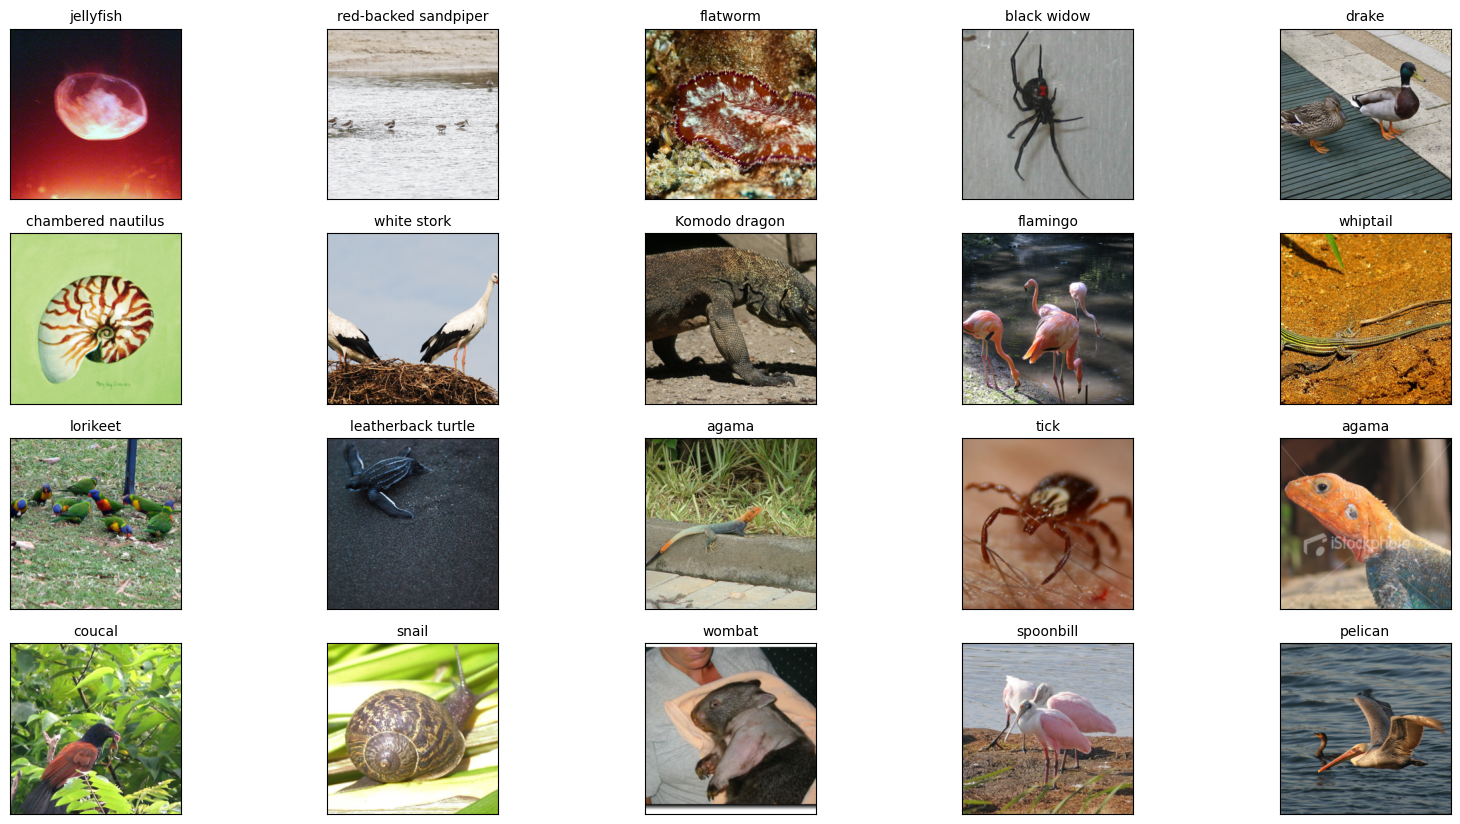

torch.Size([128, 3, 256, 256])


In [3]:
for batch in data.train_dataloader:
    x, y = batch
    labels = [data.labels_idx2str[yi] for yi in y.numpy()]
    data.show_images(x.permute(0,2,3,1)[:20], labels)
    print(x.shape); break

### Architecture

Network In Network (NIN) tackles two main issues:
- Fully connected (FC) layers consumes a large number of parameters. Thus, is prone to overfitting
- It is impossible to add FC layers at the beginning of the network to increase the degree of nonlinearity

The paper proposed:
- use 1x1 convolutional layers to add non local nonlinearities across the channel activations
- use global average pooling to in the last layer which output the spatial average of the feature maps from the last convolutional layer

The basis idea was to apply FC layer at each pixel location. And the 1x1 convolution does it independently on each pixel.

NIN uses micro neural networks (mlpconv in the paper layers) with more complex structures to gain more representation for feature maps. Thus the NIN architecture is a stack of multiple mlpconv.

The global average pooling is very important as it replaces traditional FC layers which led to overfitting, acts as a regularizer and has no parameters, and treat the convolutional layers as feature extractor.

The mlpconv is a mini-network composed of 3 convolutional layers and aims to extract features of local:
- a first convolutional layer of choosen kernel size to extract features
- two convolutional layers to perform a weighted linear recombination on the input feature maps.

Each convolutional is follow bu a ReLU activation and each mlpconv is followed by a maxpool layer to half height and width of feature maps.

This design offers flexibility in the parameters of each mlpconv. Thus we filled the channels parameters of mlpconv layers based on Alexnet channels numbers. This model has less parameters than Alexnet as the FC consumes the most part of parameters. As the FC layers are no longer used, we used 510 channels after the 384 channels.

In [4]:
import model

In [5]:
network_in_network = model.NetworkInNetwork(num_classes=num_classes)
network_in_network

NetworkInNetwork(
  (0): NiNBlock(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Dropout(p=0.5, inplace=False)
  (3): NiNBlock(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): ReLU()
  )
  (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.5, inplace=False)
  (6): NiNBlock(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(384,

In [6]:
network_in_network[0]

NiNBlock(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
  (1): ReLU()
  (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (3): ReLU()
  (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (5): ReLU()
)

For the last mlpconv the output channels number is the number of classes to classify.

In [7]:
network_in_network[-3]

NiNBlock(
  (0): Conv2d(512, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): ReLU()
  (2): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (3): ReLU()
  (4): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (5): ReLU()
)

In [8]:
def compute_number_params(model):
    num_total_params = 0
    for _, params in model.named_parameters():
        if params.requires_grad:
            num_total_params += params.numel()
    return num_total_params

In [9]:
print("Number of parameters of Network In Network:", compute_number_params(network_in_network))

Number of parameters of Network In Network: 4752960


### Training

Data augmentation was used. We used the first form presented in the paper. As the ImageNet-100 dataset have not fixed-size images, we reshaped the images to 2X6x256 and made random extraction of 224x224 patches. We enable a random horitontal flip of 0.5 probability and normalization accross each RGB channel. Plus we implemented pixel alteration using PCA mentionned in the paper. Actually we used Iterative PCA as the data is very large.

For the training, the setup is (same we used for Alexnet training on Imagenet-100):
- Optimizer: SGD + momentum of $0.9$
- Learning rate is initializd at $0.01$ and divided by $10$ when the valdiation loss stop improving. Weight decay of $0.0005$ is applied for regularization
- Loss: CrossEntropy
- Epochs: 90
- Batch size: 64

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

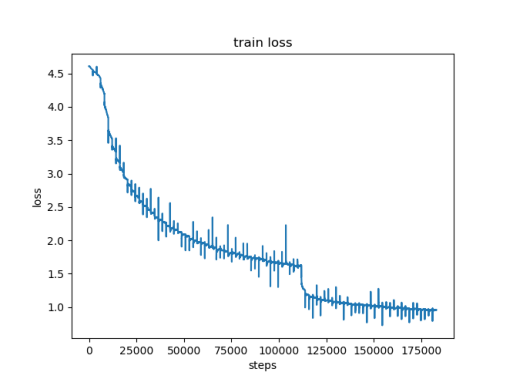

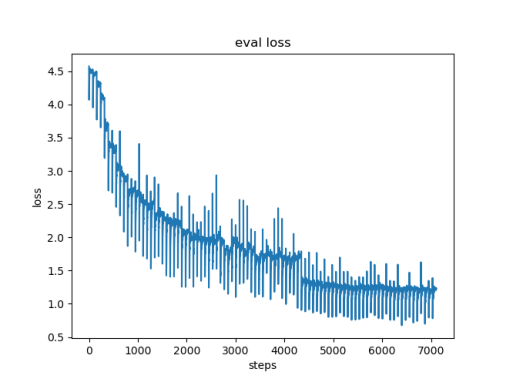

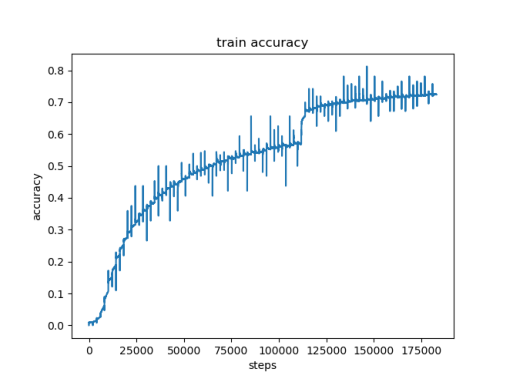

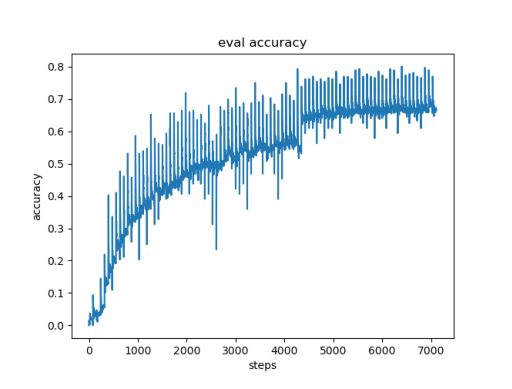

In [11]:
for metric in ["loss", "accuracy"]:
    for set_name in ["train", "eval"]:
        img = Image.open(f"{set_name}-{metric}.png")
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.show()

We used only accuracy as metrics because the dataset is balanced. We can see our model overfitted. We should have used the second form of data augmentation mentionned in the paper which tackles altering the intensities of the RGB channems in training images.

In [12]:
!cat training-network-in-network.log | tail -n 5

2025-06-10 03:45:45 [INFO] [Epoch 90/90] [Step 181848] train_loss: 0.95444, train_acc: 0.72456
2025-06-10 03:47:19 [INFO] [Epoch 90/90] [Step 182348] train_loss: 0.95442, train_acc: 0.72504
2025-06-10 03:48:51 [INFO] [Epoch 90/90] [Step 182848] train_loss: 0.95742, train_acc: 0.72450
2025-06-10 03:49:15 [INFO] [Epoch 90/90] train_loss: 0.95855, train_acc: 0.72421, eval_loss: 1.23346, eval_acc: 0.66580
2025-06-10 03:49:15 [INFO] Model saved at network-in-network.pth


In [13]:
import torch

import dataset

We propose the confusion matrix on the validation dataset used during training.

In [14]:
batch_size = 128
data = dataset.ImageNet100(batch_size=batch_size)
num_classes = data.num_classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network_in_network.load_state_dict(torch.load("network-in-network.pth"))
network_in_network.to(device)
network_in_network.eval()

/tmp/ipykernel_289175/2425192593.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network_in_network.load_state_dict(torch.load("network-in-network.pth"))


NetworkInNetwork(
  (0): NiNBlock(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Dropout(p=0.5, inplace=False)
  (3): NiNBlock(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): ReLU()
  )
  (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.5, inplace=False)
  (6): NiNBlock(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(384,

### Topk error

In [15]:
def compute_top_k_error(model, eval_dataloader, k: int=5):
    topk_acc = 0
    num_instances = 0
    for batch in eval_dataloader:
        batch = [a.to(device) for a in batch]
        with torch.no_grad():
            output = model(*batch[:-1])
            _, pred = output.topk(k, dim=1)
            topk_acc += (pred==batch[-1].view(-1, 1).expand_as(pred)).any(dim=-1).float().sum().item()
            num_instances += batch[-1].size(0)
    topk_acc /= num_instances
    return topk_acc, 1-topk_acc

In [16]:
for k in range(1, 6, 2):
    topk_acc, topk_error = compute_top_k_error(model=network_in_network, eval_dataloader=data.eval_dataloader, k=k)
    print(f"NetworkInNetwork: top{k}_accuracy: {topk_acc:.5f}, top{k}_error: {topk_error:.5f}")

NetworkInNetwork: top1_accuracy: 0.66580, top1_error: 0.33420
NetworkInNetwork: top3_accuracy: 0.83200, top3_error: 0.16800
NetworkInNetwork: top5_accuracy: 0.88560, top5_error: 0.11440


|                                    | Alexnet           | NetworkInNetwork |
|:-----------------------------------|:------------------|:-----------------|
| Number of layers                   | 8                 | 12               |
| Number of conv layers              | 5                 | 12               |
| Number of dense layers             | 3                 | 0                |
| Local repose normalization         | yes               | no               |
| Number of parameters (M)           | ~58.7             | ~4.75            |
| Train max epochs                   | 90                | 90               |
| Training duration                  | 12 hours 34 mins  | 9 hours 50 mins  |
| Top1_acc (%)                       | 68.38             | 66.58            |
| Top3_acc (%)                       | 84.24             | 83.20            |
| Top5_acc (%)                       | 88.72             | 88.56            |

We achieved comparable results using NetworkInNetwork (AlexNet-like configuration) model with 12 times less trainable parameters. Plus the training was faster.